# Calculate doctor capacity

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse
from os.path import join
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
data_path = 'data'  
file_name = 'matched_and_imputed_doctors.csv'

In [3]:
# load the matched and filtered doctor data (only doctors with > 1000 patients / year)
opening_hours = pd.read_csv(join(data_path, file_name))

# calculate quarterly patient numbers (as in Ruggiero's PNAS paper)
opening_hours['N_total_quarterly_patients'] = \
            opening_hours['N_total_yearly_patients'] / 4
opening_hours['N_total_quarterly_patients'] = \
            opening_hours['N_total_quarterly_patients'].round().astype(int)
opening_hours['N_unique_quarterly_patients'] = \
            opening_hours['N_unique_yearly_patients'] / 4
opening_hours['N_unique_quarterly_patients'] = \
            opening_hours['N_unique_quarterly_patients'].round().astype(int)

specs = opening_hours['specialization'].unique()

## Model 1: flat capacity estimate

In [4]:
# capacity increase factor: all capacities are increased by 10%
C = 0.1
opening_hours['capacity_total_flat'] = \
            opening_hours['N_total_quarterly_patients'] * (1 + C)
opening_hours['capacity_total_flat'] = \
            opening_hours['capacity_total_flat'].round().astype(int)
opening_hours['capacity_unique_flat'] = \
            opening_hours['N_unique_quarterly_patients'] * (1 + C)
opening_hours['capacity_unique_flat'] = \
            opening_hours['capacity_unique_flat'].round().astype(int)

## Model 2: opening hour based capacity

For opening hour intervals of 5 opening hours: calculate the median patient capacity (patients per quarter) of the upper 10% of doctors. Assign this median capacity to all doctors that do not belong to the doctors within the upper 10% of capacity.

In [5]:
opening_hours['capacity_total_hour-based'] = opening_hours['N_total_quarterly_patients']
opening_hours['capacity_unique_hour-based'] = opening_hours['N_unique_quarterly_patients']

# threshold for the upper percentile: the "maximum capacity" will be calculated
# as the median capacity of doctors in the upper (1-threshold) % of 
# doctors in a given speciality and hour bracket. The capacities of the doctors
# in the lower threshold % will be set to this maximum capacity
threshold = 0.9   ###0.9 original main setting

# hour bracket for which upper capacities will be calculated
hour_range_interval = 5
hour_ranges = np.arange(0, opening_hours['total_weekly_hours'].max(), hour_range_interval)

# iterate through all specializations
for spec in specs:
    # extract data from doctors from the current specialization
    spec_data = opening_hours[opening_hours['specialization'] == spec]
    # dictionary of the upper percentile medians in each hour-bracket for
    # the given speciality
    upper_percentile_medians = {i:np.nan for i in hour_ranges}
    
    # iterate through all hour brackets
    for iv_start in hour_ranges:
        # extract the data from doctors whose opening hours fall in the given
        # hour bracket
        interval_data = spec_data[ \
            (spec_data['total_weekly_hours'] >= iv_start) & \
            (spec_data['total_weekly_hours'] < iv_start + hour_range_interval)]
        
        # do the same calculation for both "unique" and "total" patient counts
        for pat_type in ['total', 'unique']:
            quantile = interval_data['N_{}_quarterly_patients'\
                                        .format(pat_type)].quantile(threshold)

            # calculate the median capacity of the upper (1-threshold) % of docs
            upper_median = interval_data[interval_data['N_{}_quarterly_patients'\
                    .format(pat_type)] >= quantile]['N_{}_quarterly_patients'\
                    .format(pat_type)].median()
            # find the indices of all doctors of a given speciality and hour
            # bracket that are not in the uper (1-threshold) % of capacities
            lower_index = interval_data[interval_data['N_{}_quarterly_patients'\
                                    .format(pat_type)] < quantile].index
            
            # if the number of doctors in the lower threshold % of capacities is
            # non-zero: set their capacities to the maximum capacity
            if len(lower_index) > 0:
                opening_hours.loc[lower_index, 'capacity_{}_hour-based'\
                                .format(pat_type)] = upper_median

            
opening_hours['capacity_total_hour-based'] = \
        opening_hours['capacity_total_hour-based'].round().astype(int)
opening_hours['capacity_unique_hour-based'] = \
        opening_hours['capacity_unique_hour-based'].round().astype(int)

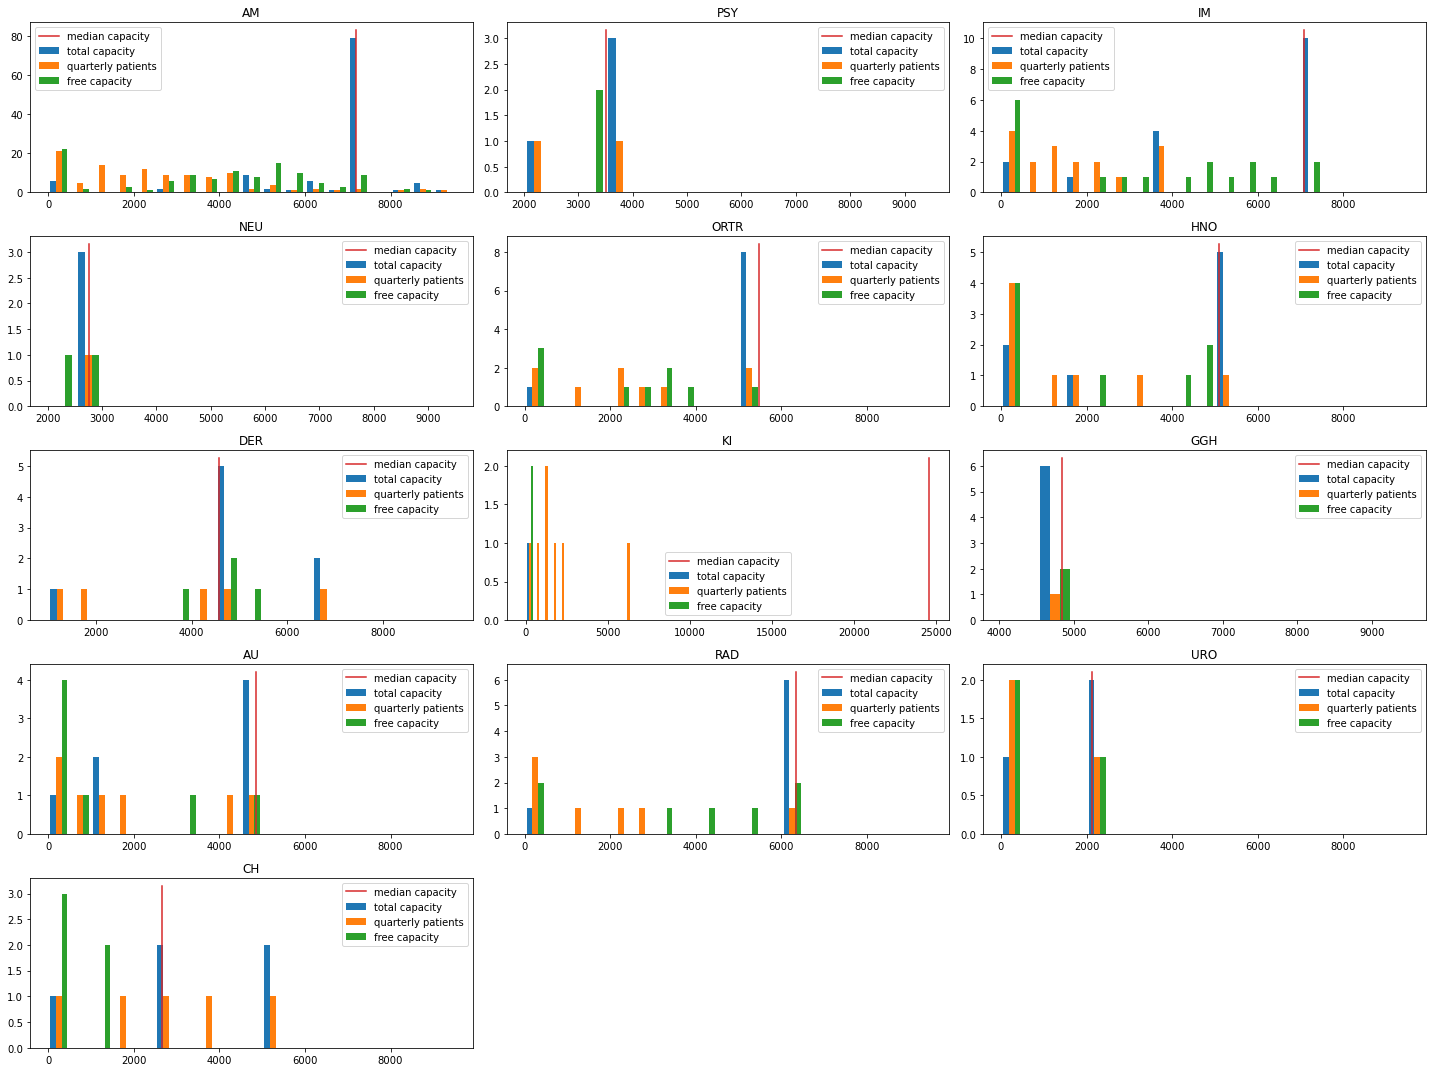

In [6]:
# visulaize capacities
fig, axes = plt.subplots(5, 3, figsize=(20, 15))
for spec, ax in zip(specs, axes.flatten()):
    spec_data = opening_hours[opening_hours['specialization'] == spec]
    median = spec_data['capacity_total_hour-based'].median()
    ax.hist([spec_data['capacity_total_hour-based'], spec_data['N_total_quarterly_patients'],\
             spec_data['capacity_total_hour-based'] - spec_data['N_total_quarterly_patients']],
             rwidth = 0.8, bins=range(int(spec_data['capacity_total_hour-based'].min()/1000)*1000, 10000, 500),
             label=['total capacity', 'quarterly patients', 'free capacity'])
    ax.plot([median, median], ax.get_ylim(), label='median capacity')
    ax.set_title(spec)
    ax.legend()
    
axes[4, 1].remove()
axes[4, 2].remove()
fig.tight_layout()

## Model 3: maximum capacity

For doctors that are not yet in the top 25 percentile of patient capacity, assign the median value of the top 25 percentile as capacity (regardless of opening hours).

In [7]:
def get_upper_median(data, spec, pat_type):
    spec_data = data[data['specialization'] == spec]
    quant_75 = spec_data['N_{}_quarterly_patients'.format(pat_type)].quantile(0.75)
    quant_median = spec_data[spec_data['N_{}_quarterly_patients'.format(pat_type)] >=\
                             quant_75]['N_{}_quarterly_patients'.format(pat_type)].median()
    return quant_median, quant_75

In [8]:
opening_hours['capacity_total_max'] = opening_hours['N_total_quarterly_patients']
opening_hours['capacity_unique_max'] = opening_hours['N_unique_quarterly_patients']

for spec in specs:
    for pat_type in ['total', 'unique']:
        upper_median, quant_75 = get_upper_median(opening_hours, spec, pat_type)
        print('[{}, {}]: upper median {}, 75th percentile {}'.format(spec, pat_type, upper_median, quant_75))
        lower_index = opening_hours[(opening_hours['specialization'] == spec) & \
                                    (opening_hours['N_{}_quarterly_patients'.format(pat_type)] < quant_75)].index
        opening_hours.loc[lower_index, 'capacity_{}_max'.format(pat_type)] = upper_median
        
opening_hours['capacity_total_max'] = opening_hours['capacity_total_max'].round().astype(int)
opening_hours['capacity_unique_max'] = opening_hours['capacity_unique_max'].round().astype(int)

[AM, total]: upper median 5206.0, 75th percentile 3896.5
[AM, unique]: upper median 2123.0, 75th percentile 1735.5
[PSY, total]: upper median 3500.0, 75th percentile 2601.5
[PSY, unique]: upper median 1450.0, 75th percentile 1050.25
[IM, total]: upper median 3664.0, 75th percentile 2698.75
[IM, unique]: upper median 1853.0, 75th percentile 1439.5
[NEU, total]: upper median 2760.0, 75th percentile 1758.5
[NEU, unique]: upper median 1131.0, 75th percentile 813.5
[ORTR, total]: upper median 5043.0, 75th percentile 3218.0
[ORTR, unique]: upper median 1879.0, 75th percentile 1842.0
[HNO, total]: upper median 4052.0, 75th percentile 2227.5
[HNO, unique]: upper median 2834.5, 75th percentile 1639.75
[DER, total]: upper median 5717.0, 75th percentile 4234.5
[DER, unique]: upper median 2000.0, 75th percentile 1630.5
[KI, total]: upper median 15314.5, 75th percentile 3254.75
[KI, unique]: upper median 9696.5, 75th percentile 1475.0
[GGH, total]: upper median 3886.5, 75th percentile 2641.25
[GGH,

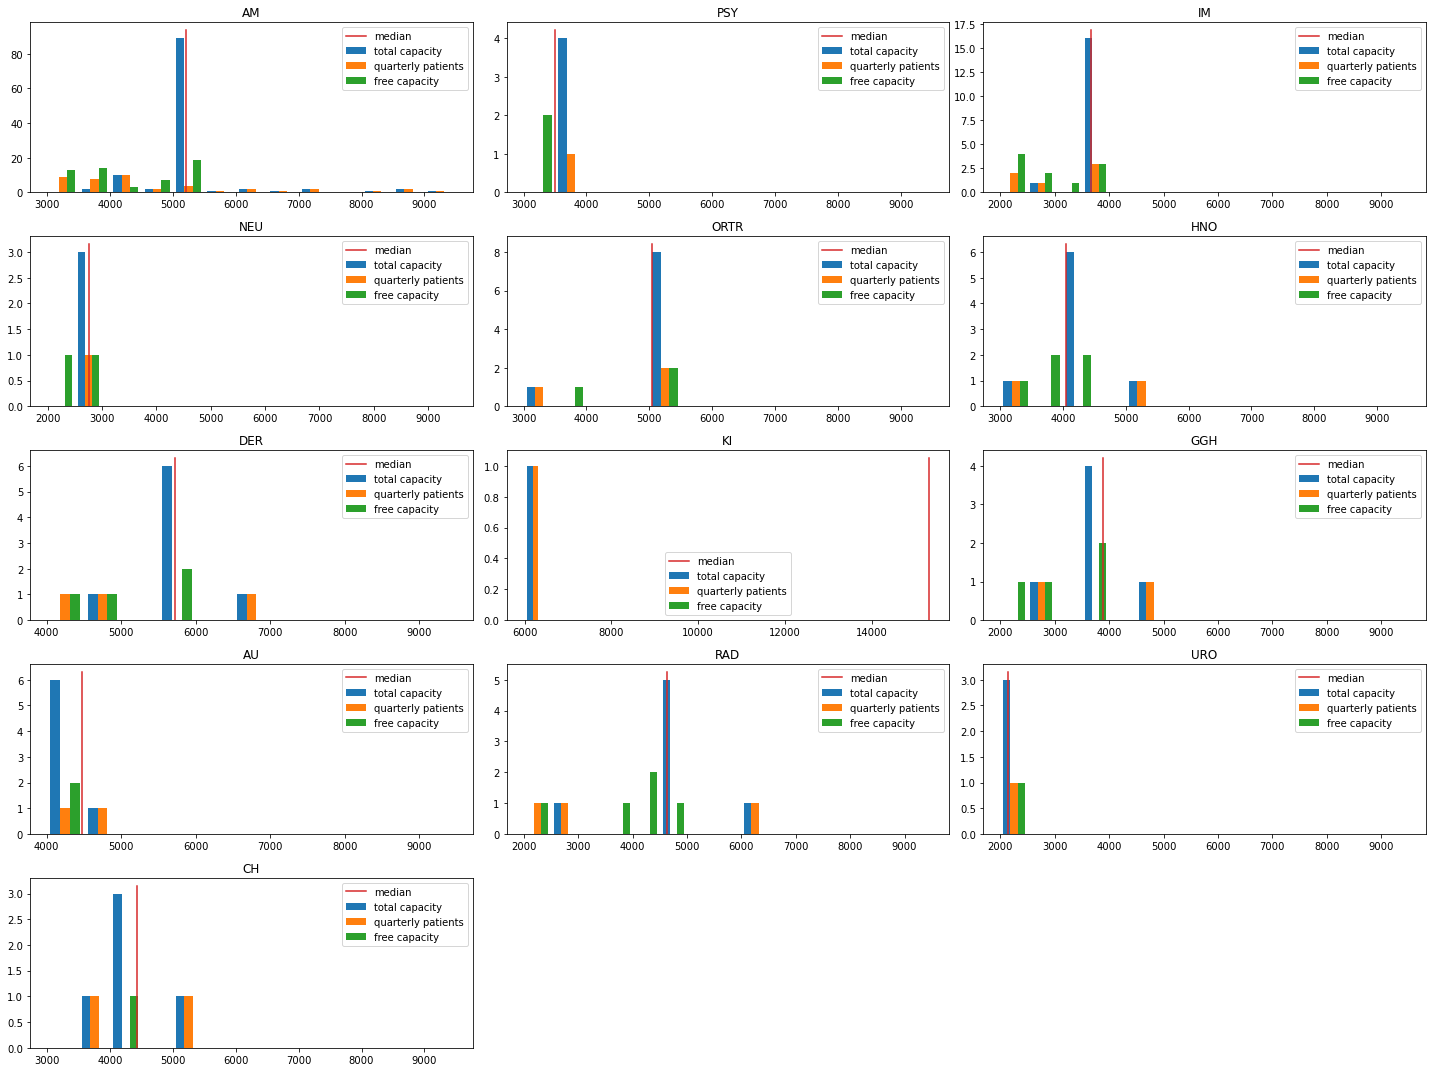

In [9]:
fig, axes = plt.subplots(5, 3, figsize=(20, 15))
for spec, ax in zip(specs, axes.flatten()):
    spec_data = opening_hours[opening_hours['specialization'] == spec]
    median = spec_data['capacity_total_max'].median()
    ax.hist([spec_data['capacity_total_max'], spec_data['N_total_quarterly_patients'],
             spec_data['capacity_total_max'] - spec_data['N_total_quarterly_patients']],
             rwidth = 0.8, bins=range(int(spec_data['capacity_total_max'].min()/1000)*1000, 10000, 500),
             label=['total capacity', 'quarterly patients', 'free capacity'])
    ax.plot([median, median], ax.get_ylim(), label='median')
    ax.set_title(spec)
    ax.legend()
    
axes[4, 1].remove()
axes[4, 2].remove()
fig.tight_layout()

## Save the data

In [10]:
today = datetime.now().date()
opening_hours['adj_index'] = opening_hours.index
opening_hours.to_csv('data/matched_and_imputed_doctors_with_capacity_threshold{}.csv'.format(threshold),
                     index=False)